In [2]:
import sys

ssh = True
if ssh:
    data_folder = "/home/gperri-ext/master_thesis/data//"
    sys.path.append('/home/gperri-ext/master_thesis/')
else:
    data_folder = r"C:\Users\Giova\thesis\master_thesis\data//"
    sys.path.append(r"C:\Users\Giova\thesis\master_thesis//")



import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # for shap

import keras_tuner as kt
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, ConvLSTM1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from modules.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from modules.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from modules.windowing_data import multivariate_data, prepare_dataset_for_training
from modules.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features
from modules.daily_errors import errors_on_rows, visualize_errors_with_timestamps, filter_errors_at_midnight, calculate_mae_errors, calculate_mape_errors, calculate_rmse_errors, calculate_nmae_errors


from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


2024-04-22 09:36:05.940448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [69]:
# # PYTHON NON RICARICA AUTOMATICAMENTE I MODULI

# from importlib import reload
# import modules.evaluation_func

# # Ricarica il modulo
# reload(modules.evaluation_func)

# # example token from https://github.com/maxbrenner-ai/seq2seq-time-series-forecasting-fully-recurrent/blob/main/notebook.ipynb


### Importing data

In [4]:
file_name = "df_SUD.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [5]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [6]:
df['holiday_d+1'] = df['holiday'].shift(-1, freq=pd.DateOffset(days=-1))
df.dropna(inplace=True)
df.drop(['holiday'], axis=1, inplace=True)

### Preparing I/O

In [7]:
df.head()

SUD  SUD_load  IT-SOUTH-SOLAR  IT-SOUTH-WIND   
Time_data                                                                   
2018-01-21 00:00:00+00:00  38.75   2273.71             0.0         1765.0  \
2018-01-21 01:00:00+00:00  34.99   2078.79             0.0         1903.0   
2018-01-21 02:00:00+00:00  30.00   1965.01             0.0         2047.0   
2018-01-21 03:00:00+00:00  27.71   1905.31             0.0         2174.0   
2018-01-21 04:00:00+00:00  25.56   1869.67             0.0         2256.0   

                             GAS  Ora  GiornoSettimana  SUD_d+1-7  holiday_d+1  
Time_data                                                                       
2018-01-21 00:00:00+00:00  19.37    1                6      42.00          1.0  
2018-01-21 01:00:00+00:00  19.37    2                6      35.15          1.0  
2018-01-21 02:00:00+00:00  19.37    3                6      32.55          1.0  
2018-01-21 03:00:00+00:00  19.37    4                6      32.78          1.0  
2018-01-21 04:00:00+00:00  19.37    5                6      32.55          1.0

In [8]:
# df.columns
# df_temp = df[['PUN','PUN_d+1-7','GAS','GiornoSettimana', 'Ora', 'holiday']]

In [9]:
dataset_input = make_yearly_dataset(df, 2018, 2021)

In [10]:
def plot_normalized_std(target_price, window_size=24):
    """
    Plot the fit and st deviation of the PUN.

    Args:
        target_price (Series): The column containing PUN values.
        window_size (int, optional): Size of the moving window for calculating trends. Defaults to 24.
    """
    # Calculate rolling mean and standard deviation
    pun_mean = target_price.rolling(window=window_size*7).mean()
    pun_std = target_price.rolling(window=window_size*7).std()

    # Calculate normalized standard deviation
    normalized_std = pun_std / pun_mean

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot mean on the first subplot
    ax1.plot(target_price.index, pun_mean, label='Mean', color='blue')
    ax1.set_ylabel('Mean')
    ax1.tick_params(axis='y')
    ax1.grid(True)
    ax1.legend()

    # Plot normalized standard deviation on the second subplot
    ax2.plot(target_price.index, normalized_std, label='Normalized Std Dev', color='orange')
    ax2.set_ylabel('Normalized Std Dev')
    ax2.tick_params(axis='y')
    ax2.grid(True)
    ax2.legend()

    plt.xlabel('Time Index')
    plt.grid(True)
    plt.show()

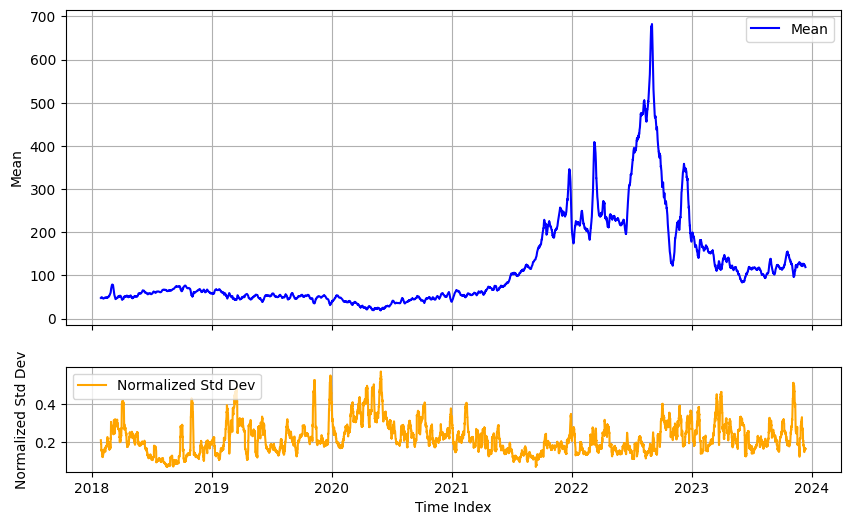

In [11]:

plot_normalized_std(df['SUD'])


In [12]:
target_size = 24
past_history = 24 
train_size = 0.7
test_size = 0.3

train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

# Arrotonda train_index e test_index al multiplo di 24 più vicino
train_index = math.ceil(train_index / 24) * 24
test_index = math.ceil(test_index / 24) * 24

In [13]:
univariate = True

X, y = prepare_dataset_for_training(dataset_input, target_column='SUD', univariate=univariate)

In [14]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [15]:
step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=0, 
                                    end_index=train_index)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=train_index,
                                )

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (24168, 24, 1)
y_train shape: (24168, 24)
X_test shape: (10320, 24, 1)
y_test shape: (10320, 24)


In [16]:
y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


### Single Trial

#### IDM forecasting (24 points at once)

In [17]:
tf.keras.backend.clear_session()

# Crea il modello LSTM
model = tf.keras.Sequential()
# return_sequences: Boolean. Whether to return the last output in the output sequence, 
# or the full sequence. Default: False.
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(150))
# model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1]))  # Output layer ha un neurone per ogni ora da prevedere
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 43224 (168.84 KB)
Trainable params: 43224 (168.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-04-22 09:36:14.401527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11243 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


In [18]:
# Definisci il callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=40,
                                batch_size=64, validation_split=0.2, 
                                callbacks = [early_stopping])

# A batch of data is a fixed-sized number of rows from the training dataset that defines
# how many patterns to process before updating the weights of the network

Train on 19334 samples, validate on 4834 samples
Epoch 1/40


2024-04-22 09:36:14.999353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11243 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-04-22 09:36:15.019922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-04-22 09:36:15.103766: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/lstm/lstm_cell/bias/v/Assign' id:655 op device:{requested: '', assigned: ''} def:{{{node training/Adam/lstm/lstm_cell/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/lstm/lstm_cell/bias/v, training/Adam/lstm/lstm_cell/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

19334/19334 [==============================] - ETA: 0s - loss: 0.0102

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-04-22 09:36:26.290640: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:218 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


19334/19334 [==============================] - 12s 643us/sample - loss: 0.0102 - val_loss: 0.0047
Epoch 2/40
19334/19334 [==============================] - 13s 650us/sample - loss: 0.0062 - val_loss: 0.0047
Epoch 3/40
19334/19334 [==============================] - 12s 629us/sample - loss: 0.0056 - val_loss: 0.0047
Epoch 4/40
19334/19334 [==============================] - 12s 608us/sample - loss: 0.0050 - val_loss: 0.0038
Epoch 5/40
19334/19334 [==============================] - 11s 583us/sample - loss: 0.0042 - val_loss: 0.0037
Epoch 6/40
19334/19334 [==============================] - 12s 635us/sample - loss: 0.0040 - val_loss: 0.0036
Epoch 7/40
19334/19334 [==============================] - 12s 628us/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 8/40
19334/19334 [==============================] - 12s 627us/sample - loss: 0.0038 - val_loss: 0.0034
Epoch 9/40
19334/19334 [==============================] - 12s 623us/sample - loss: 0.0037 - val_loss: 0.0035
Epoch 10/40
19334/19334 [=====

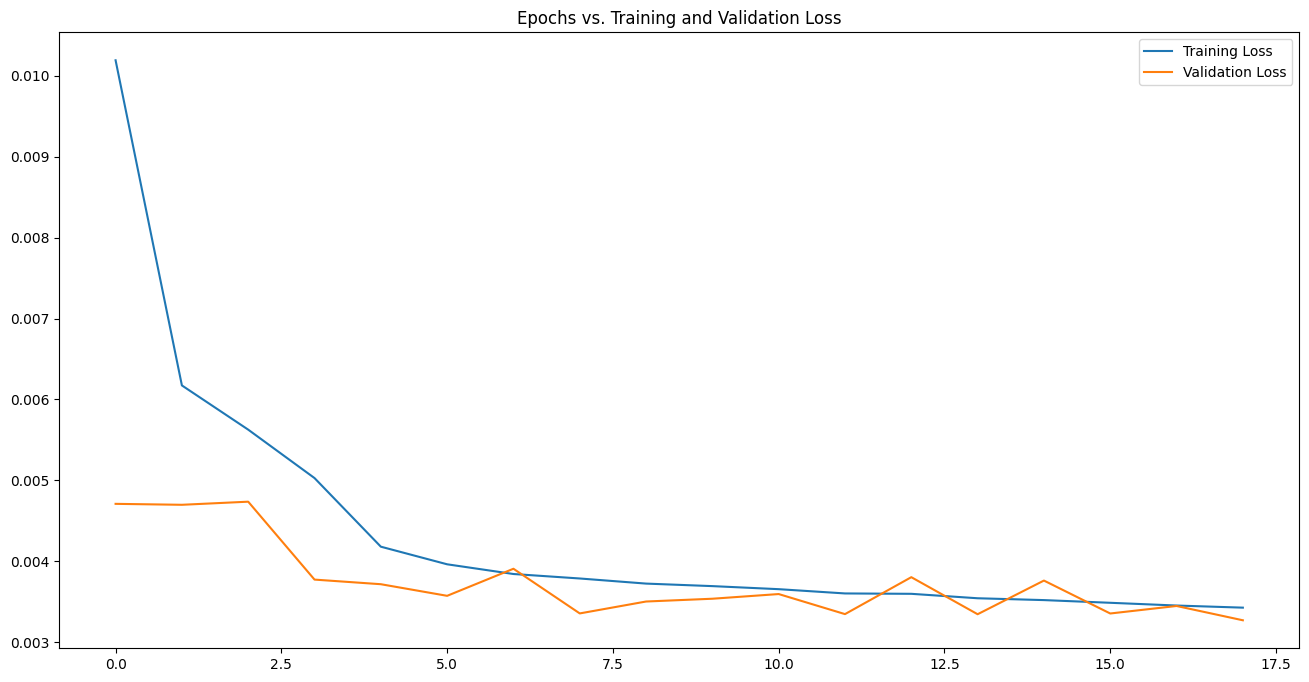

In [19]:
plot_model_loss(history)

In [20]:
# Valuta il modello
loss = model.evaluate(X_test, y_test)
print(f'Errore quadratico medio: {loss}')

# Fai previsioni per il test set
forecast = model.predict(X_test)

# Denormalizza le previsioni
lstm_forecast = y_sc.inverse_transform(forecast)



Errore quadratico medio: 0.024429157323947594


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-22 09:39:54.488818: W tensorflow/c/c_api.cc:304] Operation '{name:'dense/BiasAdd' id:200 op device:{requested: '', assigned: ''} def:{{{node dense/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense/MatMul, dense/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [21]:
y_test_inv = y_sc.inverse_transform(y_test)

In [22]:
# if univariate:
#     y_test_inv = y_sc.inverse_transform(y_test.squeeze(-1))
# else: 
#     y_test_inv = y_sc.inverse_transform(y_test)

In [23]:
# forflat = uni_lstm_forecast.flatten()

#### Error on rows 

Errore relativo a 430 giorni, a partire da mezzanotte


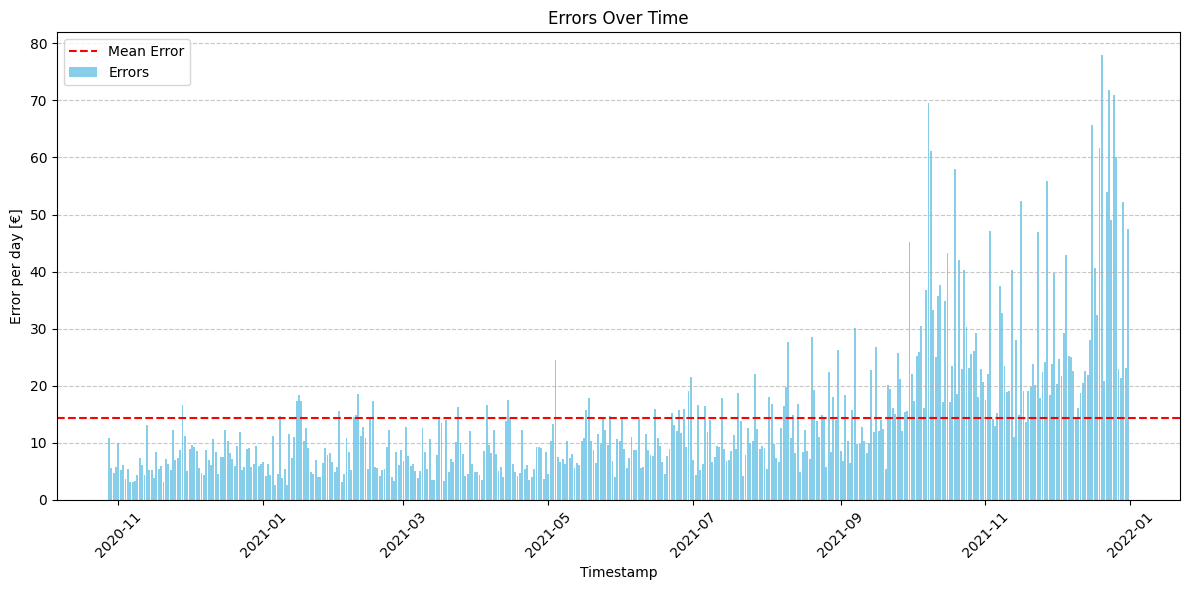

Mean Error (calculate_mae_errors): 14.306464866150257


14.306464866150257

In [24]:
errors_on_rows(y_test_inv, lstm_forecast, dataset_input, calculate_mae_errors) # l'asse y è in € solo se si usa MAE e RMSE

#### Errors on columns

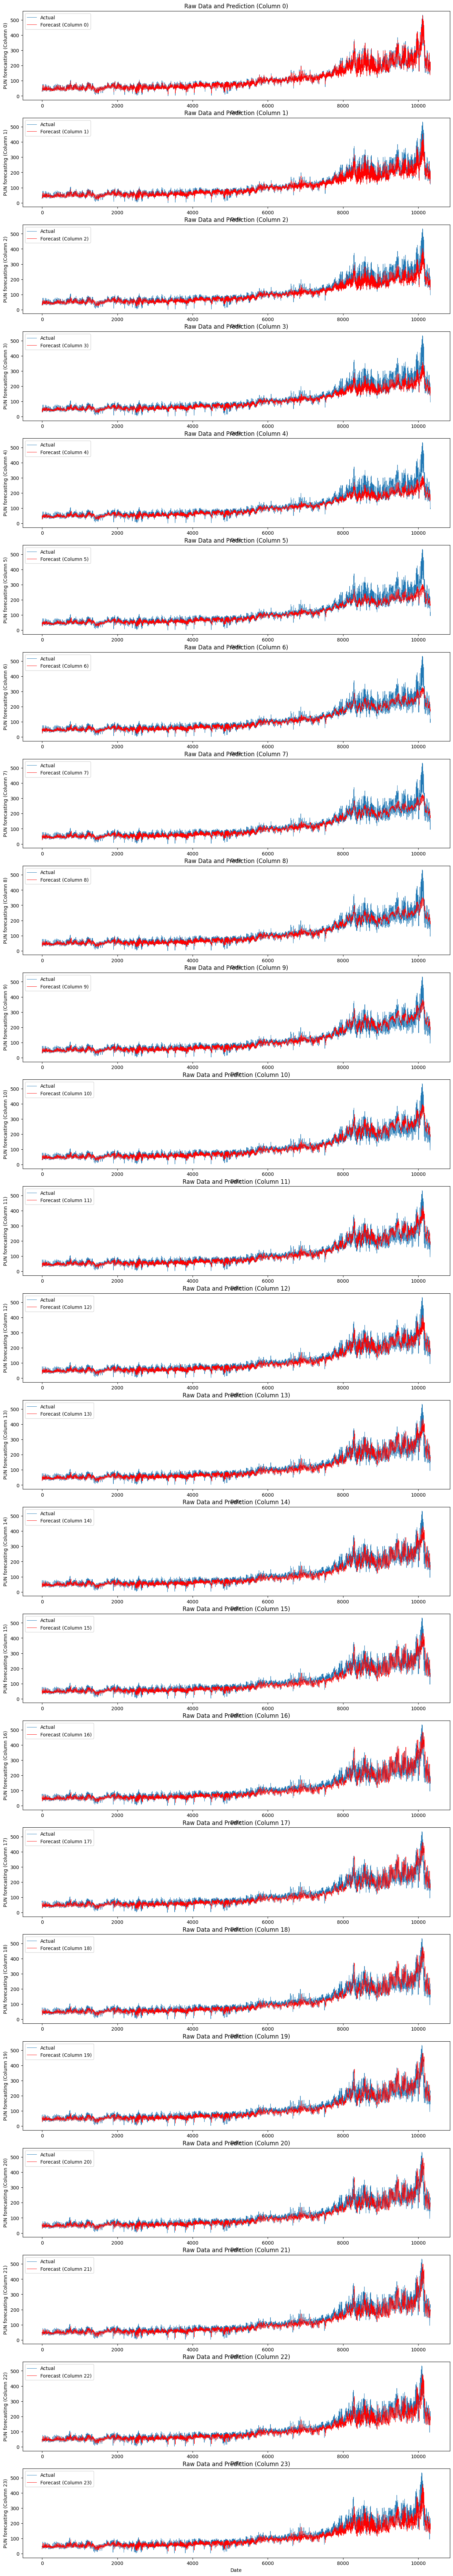

In [25]:
uni_table = evaluate_and_plot_timeseries(y_test_inv, lstm_forecast, show_plot=True)

Min NMAE: 0.088 for Column: 0.0
Min RMSE: 16.114 for Column: 0.0
Min MAPE: 9.969 for Column: 0.0
Mean NMAE: 0.13929166666666667
Mean RMSE: 25.34329166666667
Mean MAPE: 16.411791666666666


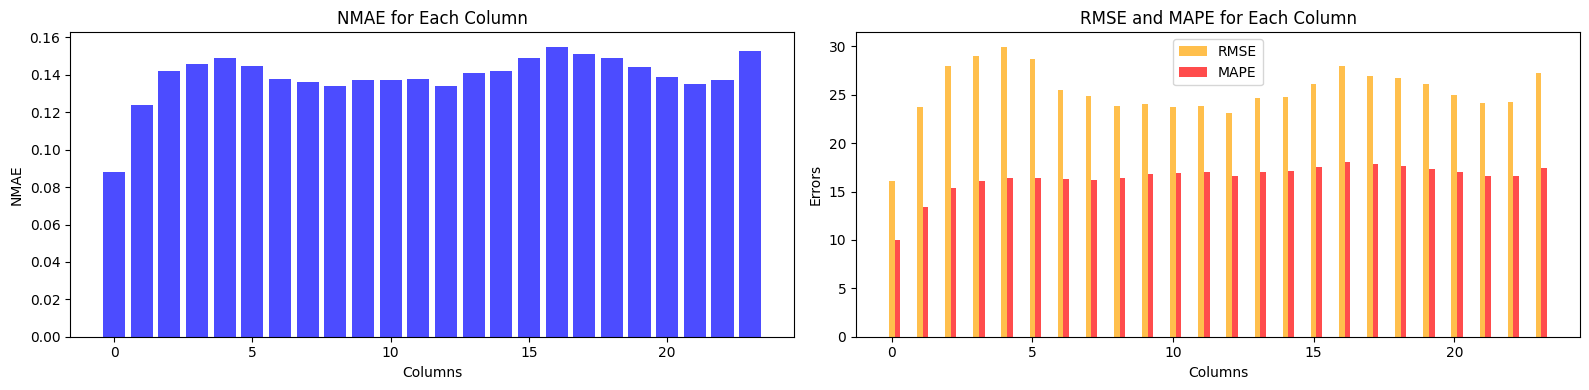

In [26]:
plot_error_metrics_barchart(uni_table)

In [27]:
# per mandarlo su papermill, devo provare ancora
# raise KeyboardInterrupt("Fine lettura")

### Encoder-Decoder LSTM Model With Univariate Input

In [28]:
# reshape output into [samples, timesteps, features]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

In [29]:
X_train[24] == y_train[0]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [30]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [31]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))

# Aggiungi RepeatVector per preparare l'input per il decoder
model.add(tf.keras.layers.RepeatVector(n_outputs))

# Aggiungi il secondo layer LSTM (decoder)
model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

# Compila il modello
model.compile(loss='mse', optimizer='adam')

# Stampa la struttura del modello
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 200)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 200)           320800    
                                                                 
 time_distributed (TimeDist  (None, 24, 100)           20100     
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 24, 1)             101       
 stributed)                                                      
                                                        

In [32]:
# Definisci il callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0002, restore_best_weights=True)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=40,
                                batch_size=64, validation_split=0.2, 
                                callbacks = [early_stopping])

# A batch of data is a fixed-sized number of rows from the training dataset that defines
# how many patterns to process before updating the weights of the network

Train on 19334 samples, validate on 4834 samples
Epoch 1/40


2024-04-22 09:40:16.526582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11243 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-04-22 09:40:16.618943: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/time_distributed/kernel/v/Assign' id:1174 op device:{requested: '', assigned: ''} def:{{{node training/Adam/time_distributed/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/time_distributed/kernel/v, training/Adam/time_distributed/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


19334/19334 [==============================] - ETA: 0s - loss: 0.0078

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-04-22 09:40:38.523512: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:417 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/time_distributed_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


19334/19334 [==============================] - 24s 1ms/sample - loss: 0.0078 - val_loss: 0.0049
Epoch 2/40
19334/19334 [==============================] - 23s 1ms/sample - loss: 0.0052 - val_loss: 0.0046
Epoch 3/40
19334/19334 [==============================] - 22s 1ms/sample - loss: 0.0051 - val_loss: 0.0052
Epoch 4/40
19334/19334 [==============================] - 23s 1ms/sample - loss: 0.0050 - val_loss: 0.0045
Epoch 5/40
19334/19334 [==============================] - 23s 1ms/sample - loss: 0.0050 - val_loss: 0.0048
Epoch 6/40
19334/19334 [==============================] - 22s 1ms/sample - loss: 0.0048 - val_loss: 0.0049
Epoch 7/40
19334/19334 [==============================] - 23s 1ms/sample - loss: 0.0045 - val_loss: 0.0042
Epoch 8/40
19334/19334 [==============================] - 23s 1ms/sample - loss: 0.0039 - val_loss: 0.0033
Epoch 9/40
19334/19334 [==============================] - 22s 1ms/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 10/40
19334/19334 [=======================

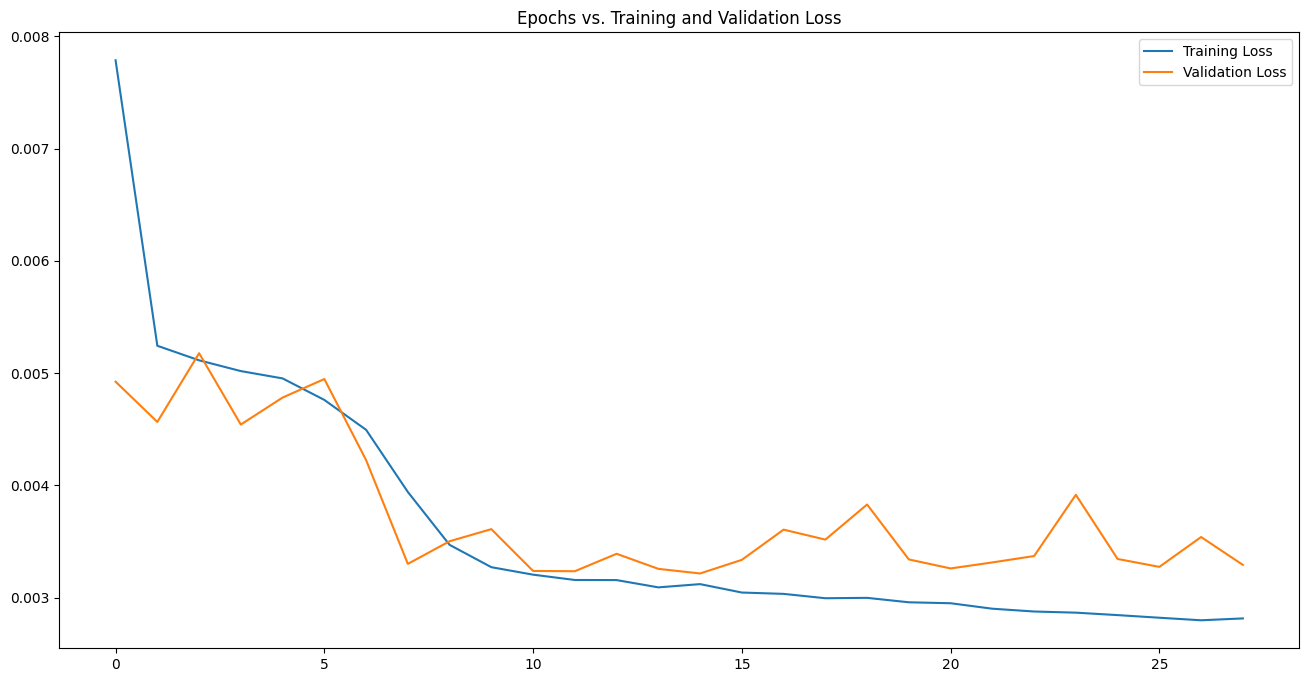

In [33]:
plot_model_loss(history)

In [34]:
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

In [35]:
# Valuta il modello
loss = model.evaluate(X_test, y_test)
print(f'Errore quadratico medio: {loss}')

# Fai previsioni per il test set
forecast = model.predict(X_test)

Errore quadratico medio: 0.13989052518068762


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-22 09:50:49.816389: W tensorflow/c/c_api.cc:304] Operation '{name:'time_distributed_1/Reshape_1' id:379 op device:{requested: '', assigned: ''} def:{{{node time_distributed_1/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](time_distributed_1/dense_1/BiasAdd, time_distributed_1/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [36]:
forecast.shape

(10320, 24, 1)

In [38]:
forecast = forecast.squeeze(-1)

In [39]:
# Denormalizza le previsioni
lstm_forecast = y_sc.inverse_transform(forecast)


In [42]:
y_test = y_test.squeeze(-1)

In [43]:
y_test_inv = y_sc.inverse_transform(y_test)

In [ ]:
# if univariate:
#     y_test_inv = y_sc.inverse_transform(y_test.squeeze(-1))
# else: 
#     y_test_inv = y_sc.inverse_transform(y_test)

In [ ]:
# forflat = uni_lstm_forecast.flatten()

#### Error on rows 

Errore relativo a 430 giorni, a partire da mezzanotte


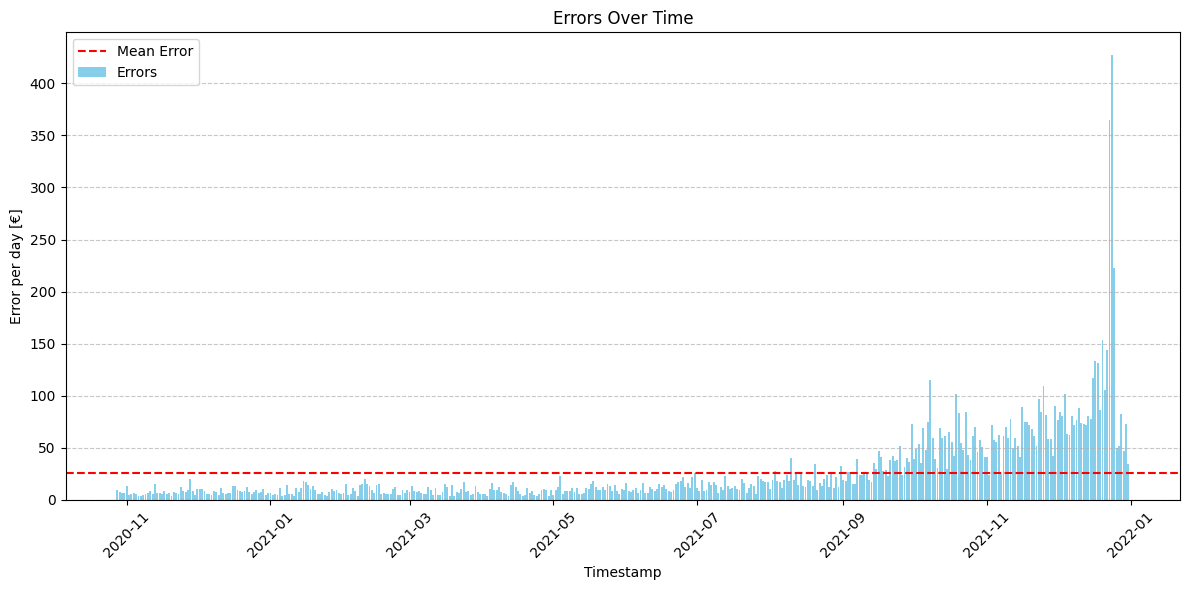

Mean Error (calculate_mae_errors): 26.346447699288063


26.346447699288063

In [44]:
errors_on_rows(y_test_inv, lstm_forecast, dataset_input, calculate_mae_errors) # l'asse y è in € solo se si usa MAE e RMSE

#### Errors on columns

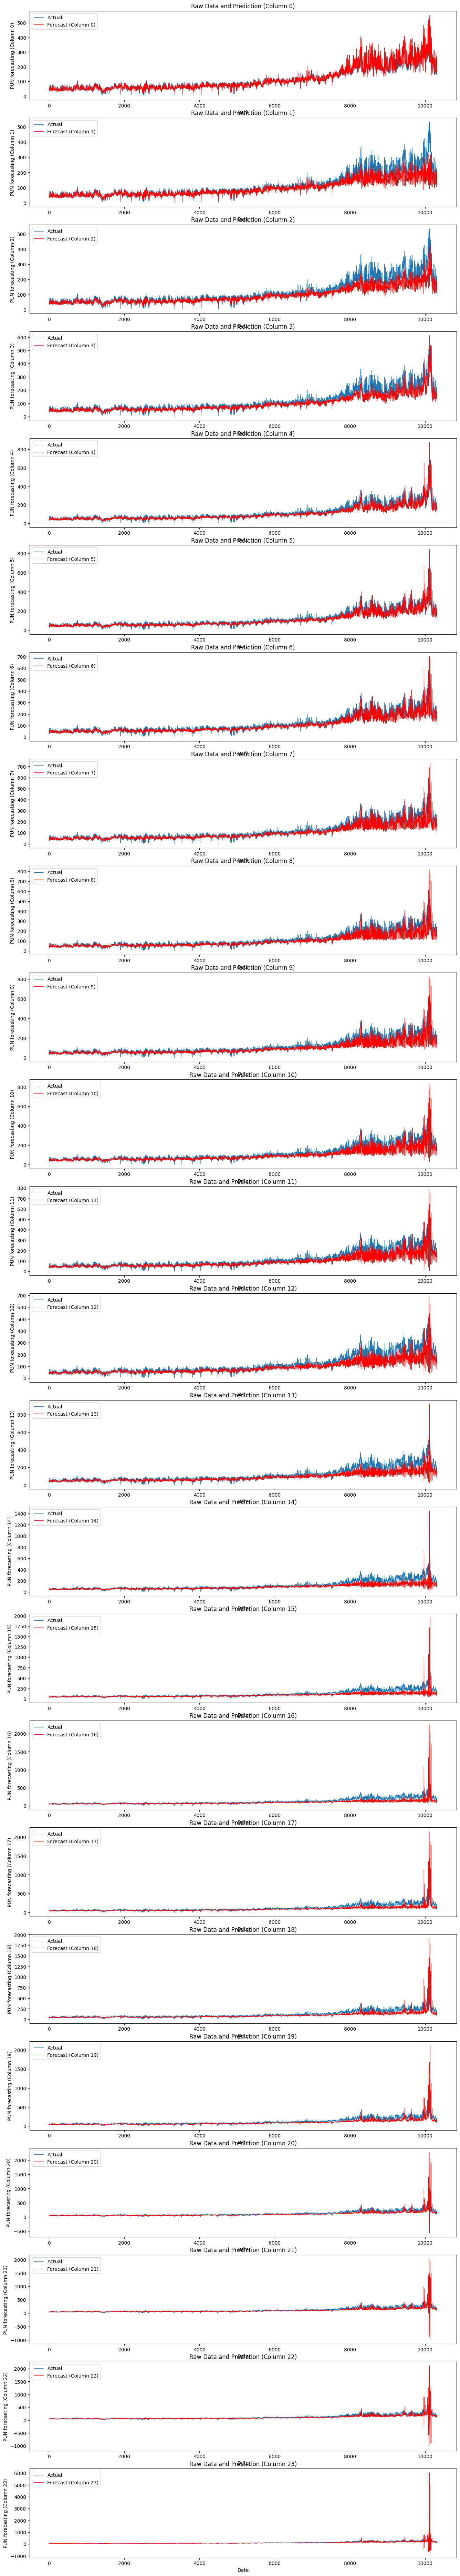

In [45]:
uni_table = evaluate_and_plot_timeseries(y_test_inv, lstm_forecast, show_plot=True)

Min NMAE: 0.066 for Column: 0.0
Min RMSE: 11.942 for Column: 0.0
Min MAPE: 8.149 for Column: 0.0
Mean NMAE: 0.22887500000000002
Mean RMSE: 55.66904166666666
Mean MAPE: 20.800958333333334


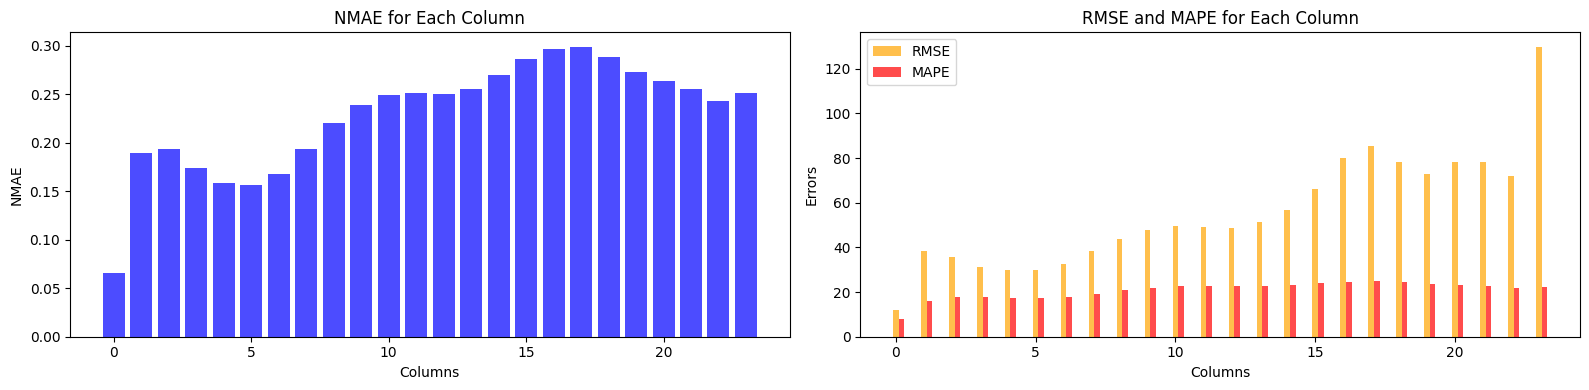

In [46]:
plot_error_metrics_barchart(uni_table)

### Multivariate

Ripreparo i dati, ponendo FALSE

In [47]:
univariate = False

X, y = prepare_dataset_for_training(dataset_input, target_column='SUD', univariate=univariate)

In [48]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [49]:
step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=0, 
                                    end_index=train_index, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=train_index,
                                    single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (24168, 24, 8)
y_train shape: (24168, 24)
X_test shape: (10320, 24, 8)
y_test shape: (10320, 24)


In [50]:
y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


In [61]:
tf.keras.backend.clear_session()
multivariate_lstm = tf.keras.Sequential()

# multivariate_lstm.add(LSTM(200, input_shape=input_shape, return_sequences=True)) 
# multivariate_lstm.add(Dropout(0.2))

multivariate_lstm.add(LSTM(100, input_shape=input_shape)) 
multivariate_lstm.add(Dropout(0.2))


# multivariate_lstm.add(Activation(custom_activation,name = "Swish"))
multivariate_lstm.add(Dense(100))
multivariate_lstm.add(Dense(target_size))


multivariate_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 56124 (219.23 KB)
Trainable params: 56124 (219.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# Callback per il salvataggio del modello
# lstm_checkpoint = ModelCheckpoint('multivariate_lstm_df_gas.h5', monitor='val_loss', save_best_only=True)

multivariate_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
# multivariate_lstm.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(1e-8, momentum=0.9) , metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

**Learning Rate Warmup**
A crucial part of the attention mechanism that leads to greater stability is learning-rate warmup. Start with a small learnign rate and gradually increase it till you reach the base one, then decrease again. You can go crazy with exponential — decaying schedules and sophisticated formulas, but I will just give you a simple example that you should be able to understand just by reading the following code out loud:

In [ ]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#             lambda epoch: 1e-5 * 10**(epoch/20))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

Train on 19334 samples, validate on 4834 samples
Epoch 1/50


2024-04-22 10:48:15.517656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11243 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-04-22 10:48:15.595694: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense/bias/v/Assign' id:695 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


19334/19334 [==============================] - ETA: 0s - loss: 0.1098 - root_mean_squared_error: 0.3314

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-04-22 10:48:26.908124: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:242 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


19334/19334 [==============================] - 12s 636us/sample - loss: 0.1098 - root_mean_squared_error: 0.3314 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1913 - lr: 1.0000e-05
Epoch 2/50
19334/19334 [==============================] - 12s 611us/sample - loss: 0.0549 - root_mean_squared_error: 0.2344 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220 - lr: 1.1220e-05
Epoch 3/50
19334/19334 [==============================] - 12s 604us/sample - loss: 0.0266 - root_mean_squared_error: 0.1632 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094 - lr: 1.2589e-05
Epoch 4/50
19334/19334 [==============================] - 11s 577us/sample - loss: 0.0210 - root_mean_squared_error: 0.1451 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018 - lr: 1.4125e-05
Epoch 5/50
19334/19334 [==============================] - 12s 609us/sample - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930 - lr: 1.5849e-05
Epoch 6/50
19334/1933

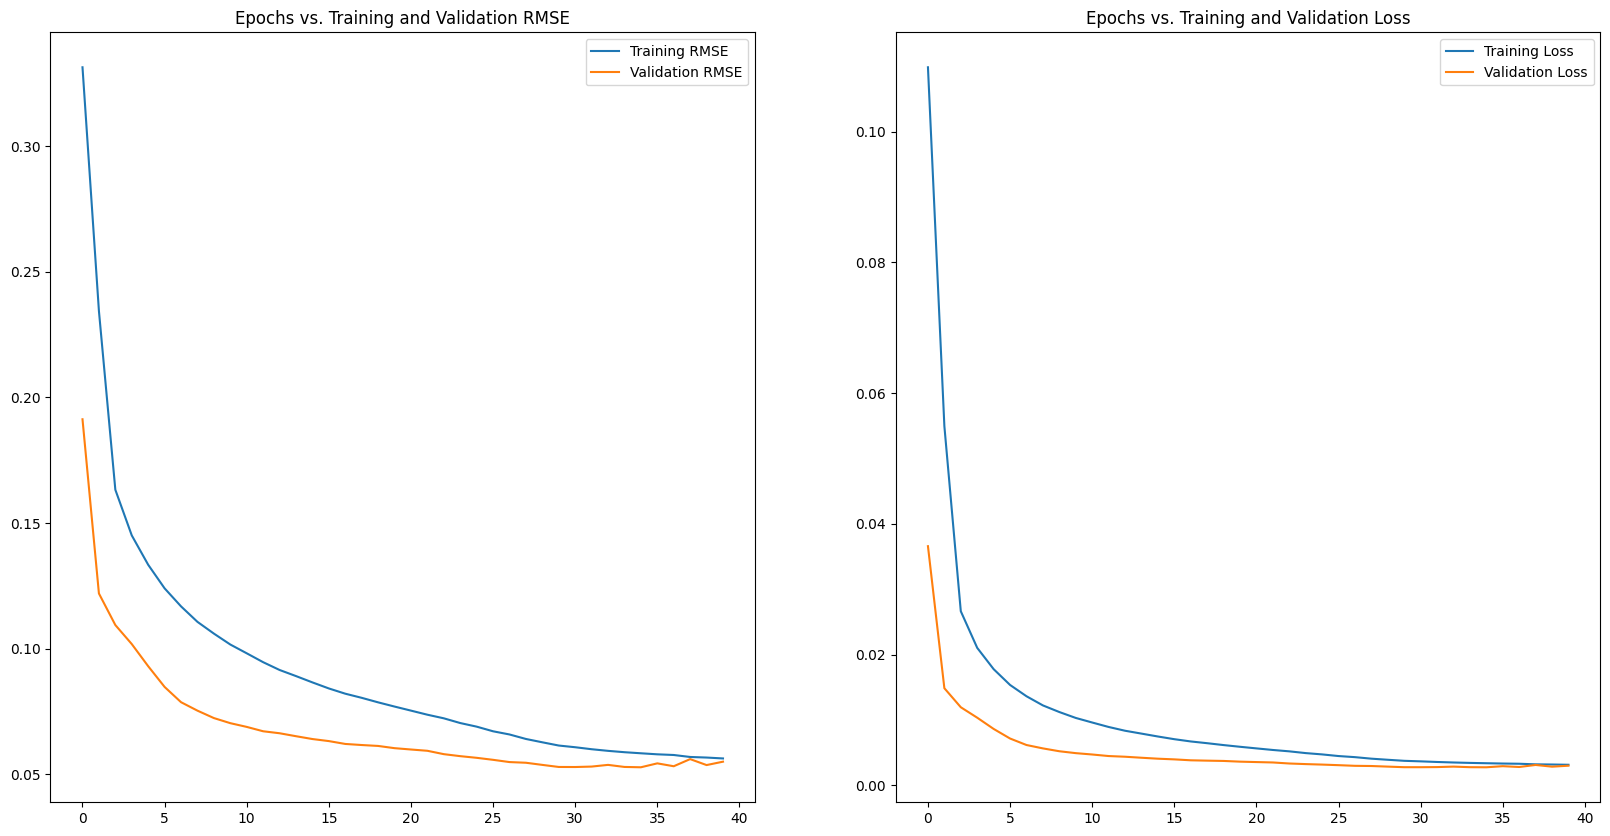

In [53]:
history = multivariate_lstm.fit(X_train, y_train, epochs=50, verbose=1,
                                validation_split=0.2, batch_size=64,
                                callbacks=[early_stopping, lr_schedule])

plot_model_rmse_and_loss(history)

In [65]:
# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-22 13:15:40.175738: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/BiasAdd' id:220 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Errore relativo a 430 giorni, a partire da mezzanotte


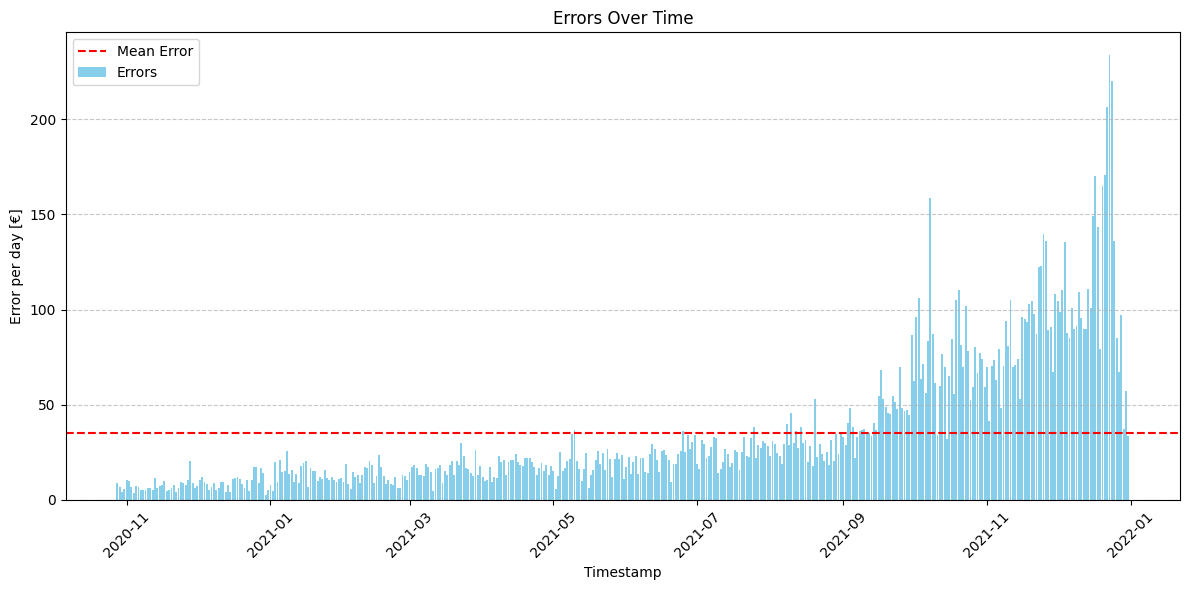

Mean Error (calculate_mae_errors): 35.22486956720944


35.22486956720944

In [66]:
errors_on_rows(y_test_inv, lstm_forecast, dataset_input, calculate_mae_errors) # l'asse y è in € solo se si usa MAE e RMSE

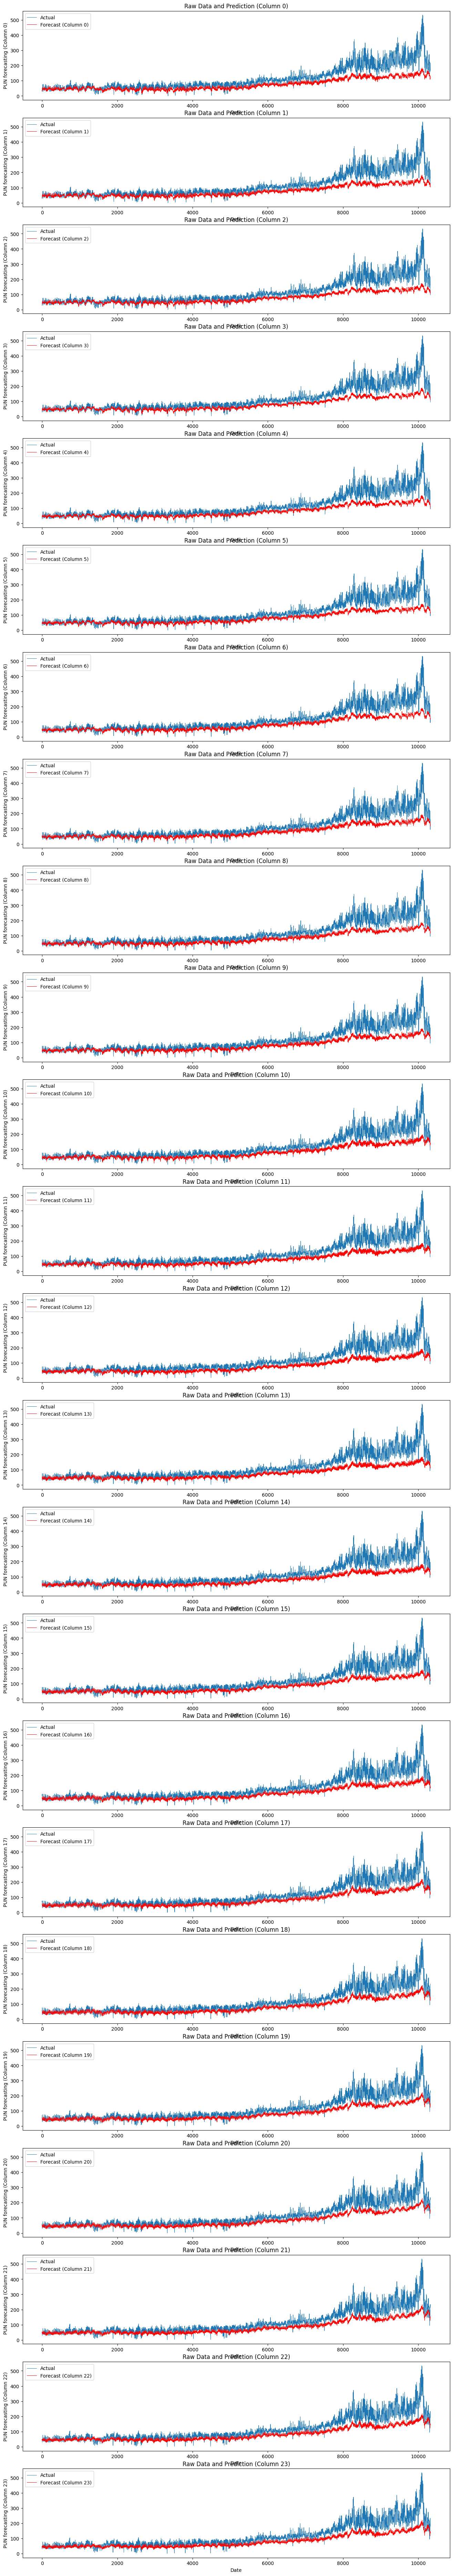

In [67]:
lstm_table = evaluate_and_plot_timeseries(y_test_inv, lstm_forecast, show_plot=True)

Min NMAE: 0.288 for Column: 20.0
Min RMSE: 48.085 for Column: 21.0
Min MAPE: 27.075 for Column: 17.0
Mean NMAE: 0.3147083333333333
Mean RMSE: 53.39579166666667
Mean MAPE: 28.49416666666666


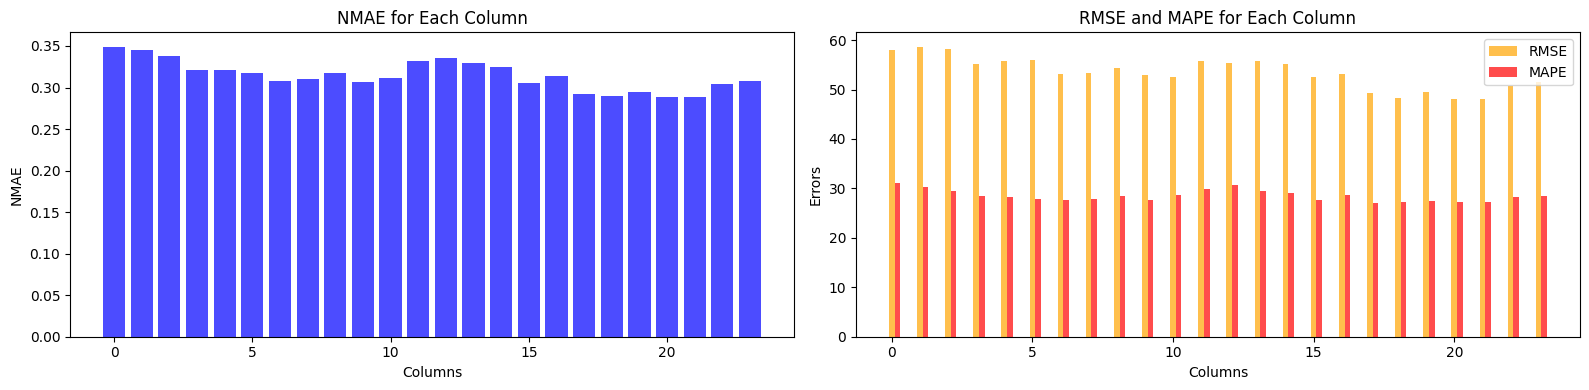

In [68]:
plot_error_metrics_barchart(lstm_table)

### Hyperparameters search

In [ ]:
# Define the model function
def build_model(hp):
  model = tf.keras.Sequential()
  # Choose the number of LSTM layers between 1 and 3
  for i in range(hp.Int('num_layers', min_value=1, max_value=2)):
    # Choose the number of LSTM units between 50 and 200
    # Check the value of num_layers to set return_sequences
    if hp.get('num_layers') == 1:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    else:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    # Choose the dropout between 0 and 0.5
    model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0, max_value=0.5, step=0.1)))
  # Add the output layer with one neuron for each hour to predict
  model.add(Dense(y_train.shape[1]))
  # Compile the model using adam as optimizer and mean_squared_error as loss function
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

tuner = kt.BayesianOptimization(build_model, objective='val_loss', max_trials=10, 
                                num_initial_points=2, beta=2.6, project_name='LSTM_tuning_multivariate_18_20_b')

tuner.search(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks = [early_stopping], verbose=2)
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 02m 42s]
val_loss: 0.002777607116262588

Best val_loss So Far: 0.0026243182138497197
Total elapsed time: 00h 18m 57s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# Print the values of each hyperparameter
print("Best number of layers:", best_hps.get("num_layers"))
print("Best number of units for layer 0:", best_hps.get("units_0"))
print("Best dropout for layer 0:", best_hps.get("dropout_0"))
# Repeat for the other layers if num_layers > 1


Best number of layers: 1
Best number of units for layer 0: 150
Best dropout for layer 0: 0.4


In [ ]:
tuned_forecast = best_model.predict(X_test)

# Denormalizza le previsioni
tuned_uni_lstm_forecast = y_sc.inverse_transform(tuned_forecast)

c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
y_test

array([[0.27689394, 0.34558081, 0.3030303 , ..., 0.19008838, 0.20707071,
        0.21912879],
       [0.34558081, 0.3030303 , 0.26167929, ..., 0.20707071, 0.21912879,
        0.24305556],
       [0.3030303 , 0.26167929, 0.23933081, ..., 0.21912879, 0.24305556,
        0.24621212],
       ...,
       [0.2707702 , 0.27045455, 0.23308081, ..., 0.3602904 , 0.33939394,
        0.31647727],
       [0.27045455, 0.23308081, 0.22910354, ..., 0.33939394, 0.31647727,
        0.29444444],
       [0.23308081, 0.22910354, 0.2102904 , ..., 0.31647727, 0.29444444,
        0.25953283]])

In [ ]:
# y_test_inv_uni = y_sc.inverse_transform(y_test.squeeze(-1))
y_test_inv_uni = y_sc.inverse_transform(y_test)

In [ ]:
# Ci sono alcuni zeri nella variabile target, che possono causare problemi con il calcolo dell'errore percentuale

null_indices = []
for i in range(y_test_inv_uni.shape[1]):
    column_null_indices = np.where(y_test_inv_uni[:, i] == 0)
    null_indices.append(column_null_indices)

# null_indices = np.where(y_test_inv_uni[:,0] == 0)
# for col in range(y_test_inv_uni.shape[1]):
#     y_test_inv_uni[null_indices, col] = 5

for i in range(y_test_inv_uni.shape[1]):
    y_test_inv_uni[null_indices[i], i] = 5

In [ ]:
# y_test_inv_uni = scaler.inverse_transform(y_test)
uni_table = evaluate_and_plot_timeseries(y_test_inv_uni, tuned_uni_lstm_forecast, show_plot=False)

Min NMAE: 0.174 for Column: 3.0
Min RMSE: 8.96 for Column: 3.0
Min MAPE: 33.132 for Column: 5.0
Mean NMAE: 0.1824583333333333
Mean RMSE: 9.299833333333334
Mean MAPE: 34.911375


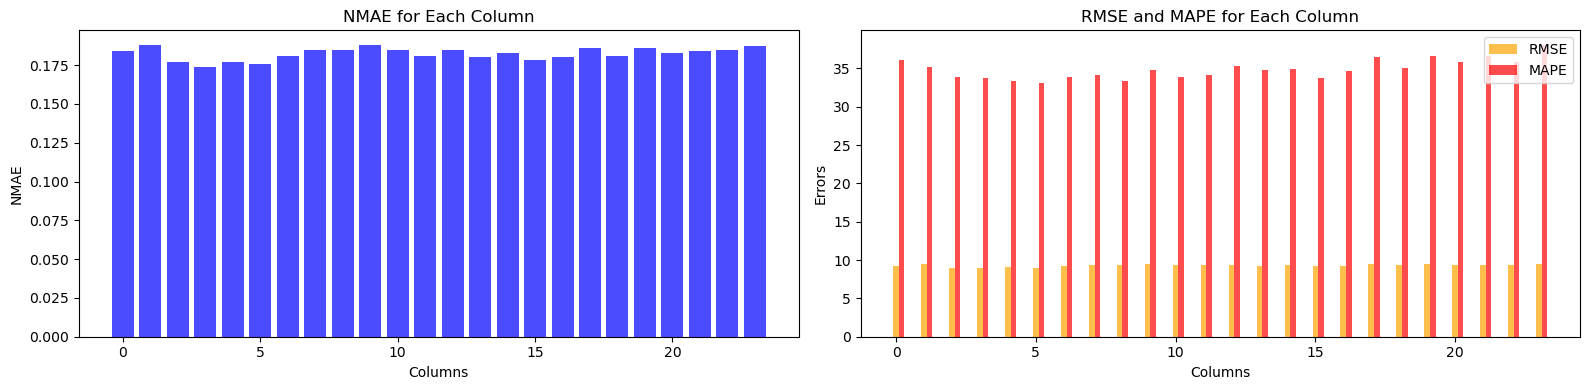

In [ ]:
plot_error_metrics_barchart(uni_table)